In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.patches as mpatches

## Biased EP Calculations

NFLFastR EP calculations take into account opponent field position after turnovers, turnovers on downs, and punts. However, they FAIL to take into account the opponent's field position after a score (field goal or touchdown). Therefore, in order to see how well my simulation matches real results (NFL Fast EPs are calculated from actual drive results), I also ignored the opponent possession after a score. Though this is not an accurate metric of Net EP, it does show that my simulation method matches reality pretty well. For better Net EP data that does not take into account NFLFastR's biases, go to data_vis_unbaised.ipynb.

First I calculate naive EPs. Naive EPs are calculated without considering opponent field position (if a drive fails, 0 is returned) as the EP data is not generated yet. With each propagation, the data takes into account prior EP simulations starting from naive EPs. The data converges with each propagation.

### Analyzing Downs

In [2]:
def analyze_data(filename, distance = 10):
    
    df = pd.read_csv(filename)
    dff = df[df['Down'] == 1]
    dff = dff[((dff['Distance'] == distance) & (dff['Yardline'] >= distance)) | ((dff['Yardline'] < distance) & (dff['Distance'] == dff['Yardline']))]

    dfs = df[df['Down'] == 2]
    dfs = dfs[((dfs['Distance'] == distance) & (dfs['Yardline'] >= distance)) | ((dfs['Yardline'] < distance) & (dfs['Distance'] == dfs['Yardline']))]

    dft = df[df['Down'] == 3]
    dft = dft[((dft['Distance'] == distance) & (dft['Yardline'] >= distance)) | ((dft['Yardline'] < distance) & (dft['Distance'] == dft['Yardline']))]

    dffo = df[df['Down'] == 4]
    dffo = dffo[((dffo['Distance'] == distance) & (dffo['Yardline'] >= distance)) | ((dffo['Yardline'] < distance) & (dffo['Distance'] == dffo['Yardline']))]

    plt.scatter(dff['Yardline'], dff['EP'], alpha=0.6, color='b', label = 'First Down')
    plt.scatter(dfs['Yardline'], dfs['EP'], alpha=0.6, color='y', label = 'Second Down')
    plt.scatter(dft['Yardline'], dft['EP'], alpha=0.6, color='g', label = 'Third Down')
    plt.scatter(dffo['Yardline'], dffo['EP'], alpha=0.6, color='r', label = 'Fourth Down')

    plt.xlabel("Yardline")
    plt.ylabel("Expected Points (EP)")
    plt.title("EP vs. Yardline (Distance = " + str(distance) + ")")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)

In [3]:
def analyze_epochs(filenames = ['biased_eps/naive_eps/EPs.csv', 'biased_eps/first_eps/EPs.csv', 'biased_eps/second_eps/EPs.csv', 'biased_eps/third_eps/EPs.csv'], down = 1, distance = 10):
    
    df = pd.read_csv(filenames[0])
    dfn = df[df['Down'] == down]
    dfn = dfn[((dfn['Distance'] == distance) & (dfn['Yardline'] >= distance)) | ((dfn['Yardline'] < distance) & (dfn['Distance'] == dfn['Yardline']))]

    df = pd.read_csv(filenames[1])
    dff = df[df['Down'] == down]
    dff = dff[((dff['Distance'] == distance) & (dff['Yardline'] >= distance)) | ((dff['Yardline'] < distance) & (dff['Distance'] == dff['Yardline']))]

    df = pd.read_csv(filenames[2])
    dfs = df[df['Down'] == down]
    dfs = dfs[((dfs['Distance'] == distance) & (dfs['Yardline'] >= distance)) | ((dfs['Yardline'] < distance) & (dfs['Distance'] == dfs['Yardline']))]

    df = pd.read_csv(filenames[3])
    dft = df[df['Down'] == down]
    dft = dft[((dft['Distance'] == distance) & (dft['Yardline'] >= distance)) | ((dft['Yardline'] < distance) & (dft['Distance'] == dft['Yardline']))]

    plt.scatter(dfn['Yardline'], dfn['EP'], alpha=0.6, color='b', label = 'Naive EPs')
    plt.scatter(dff['Yardline'], dff['EP'], alpha=0.6, color='y', label = 'First EPs')
    plt.scatter(dfs['Yardline'], dfs['EP'], alpha=0.6, color='g', label = 'Second EPs')
    plt.scatter(dft['Yardline'], dft['EP'], alpha=0.6, color='r', label = 'Third EPs')

    plt.xlabel("Yardline")
    plt.ylabel("Expected Points (EP)")
    plt.title("EP vs. Yardline (Distance = " + str(distance) + ")")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)

In [4]:
def compare_eps(file1, file2, down=1, distance=10, label1 = 'Simulated EPs', label2 = 'NFLFastR EPs'):
    df_sim = pd.read_csv(file1)
    df_real = pd.read_csv(file2)

    df_sim = df_sim[df_sim['Down'] == down]
    df_sim = df_sim[((df_sim['Distance'] == distance) & (df_sim['Yardline'] >= distance)) | ((df_sim['Yardline'] < distance) & (df_sim['Distance'] == df_sim['Yardline']))]

    df_real = df_real[df_real['Down'] == down]
    df_real = df_real[((df_real['Distance'] == distance) & (df_real['Yardline'] >= distance)) | ((df_real['Yardline'] < distance) & (df_real['Distance'] == df_real['Yardline']))]

    plt.scatter(df_sim['Yardline'], df_sim['EP'], alpha=0.6, color = 'b', label = label1)
    plt.scatter(df_real['Yardline'], df_real['EP'], alpha=0.6, color='r', label = label2)

    plt.xlabel("Yardline")
    plt.ylabel("Expected Points (EP)")
    plt.title("EP vs. Yardline (" + str(down) + "-" + str(distance) + ")")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)

In [5]:
def predicted_decisions(filename, down=4):
    dfo = pd.read_csv(filename)
    dfo = dfo[dfo['Down']==down]

    colors = {0: 'gray', 1: 'blue', 2: 'green', 3: 'red'}
    plt.figure(figsize=(15, 8))
    plt.scatter(dfo['Yardline'], dfo['Distance'], c=dfo['Opt_Choice'].map(colors), edgecolors='black', alpha=0.6)
    plt.yticks(range(1, 21))
    plt.title('Decisions Based on EP, Down='+str(down))
    plt.xlabel('Yard Line')
    plt.ylabel('Distance')
    plt.gca().invert_yaxis()

    labels = {0: 'Run', 1: 'Pass', 2: 'Kick', 3: 'Punt'}  # Use dictionary instead of list
    legend_patches = [mpatches.Patch(color=color, label=labels[choice]) for choice, color in colors.items()]
    plt.legend(handles=legend_patches, title="Optimal Choice")

In [6]:
def ep_visualizer(filename, down=1):
    dfo = pd.read_csv(filename)
    dfo = dfo[dfo['Down']==down]
    dfo = dfo[(dfo['Down']==down) & ~(dfo['Distance'] > dfo['Yardline']) & (dfo['Distance'] <= 20)]

    sc = plt.scatter(
        dfo['Yardline'], dfo['Distance'], c=dfo['EP'], cmap='inferno', edgecolors='black', alpha=0.6
    )

    cbar = plt.colorbar(sc)
    cbar.set_label("Expected Points (EP)")
    plt.yticks(range(1, 21))
    plt.gca().invert_yaxis()

    # Titles and labels
    plt.title('Expected Points, Down='+str(down))
    plt.xlabel('Yard Line')
    plt.ylabel('Distance')

### Naive EP Calculations

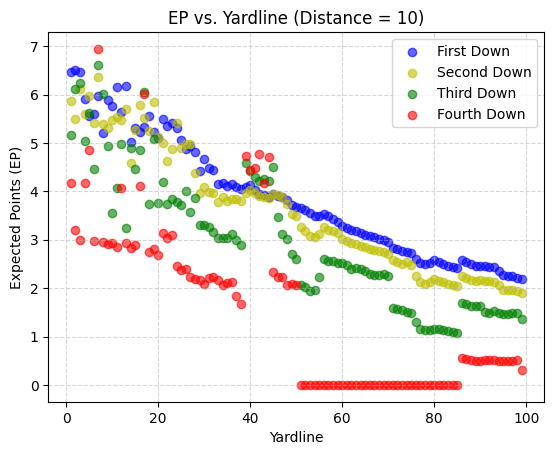

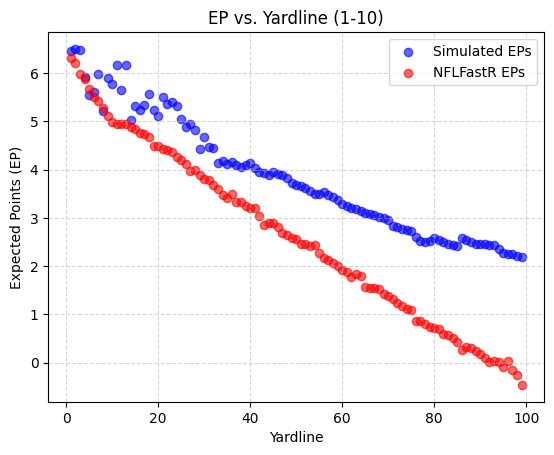

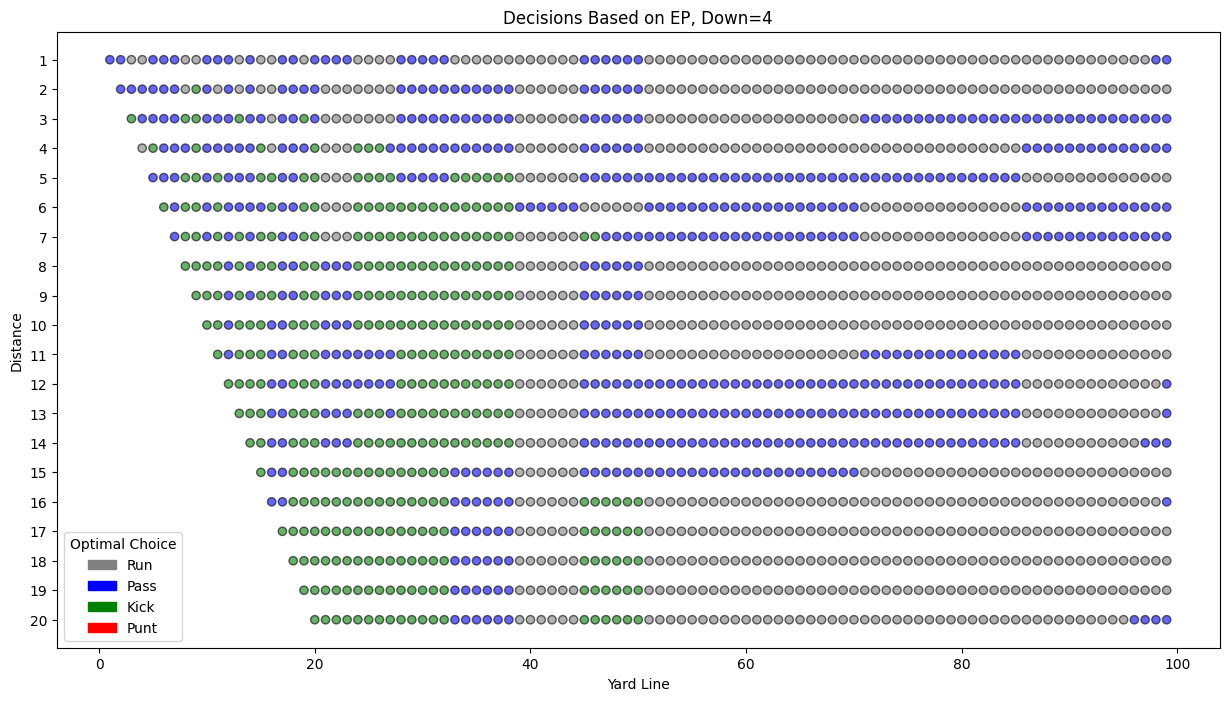

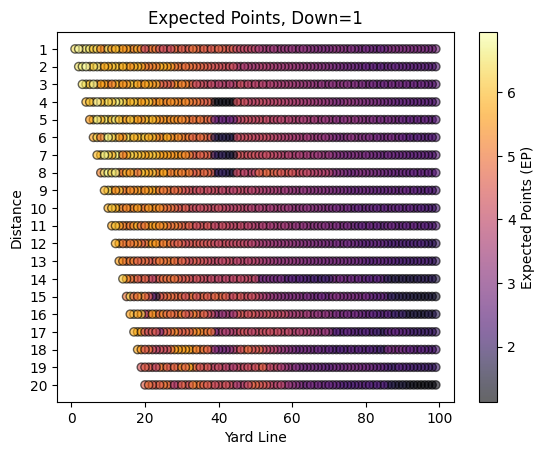

In [7]:
analyze_data('ep_data/biased_eps/naive_eps.csv')
plt.show()
compare_eps('ep_data/biased_eps/naive_eps.csv', 'aux_data/nfl_pbp_data.csv')
plt.show()
predicted_decisions('ep_data/biased_eps/naive_eps.csv')
plt.show()
ep_visualizer('ep_data/biased_eps/naive_eps.csv')
plt.show()

### EP Calculations After Three Propegations

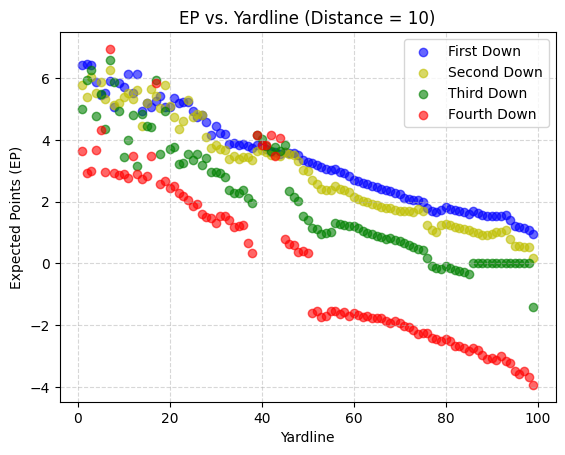

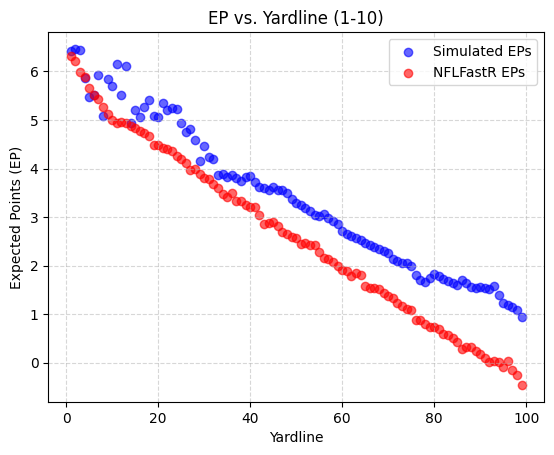

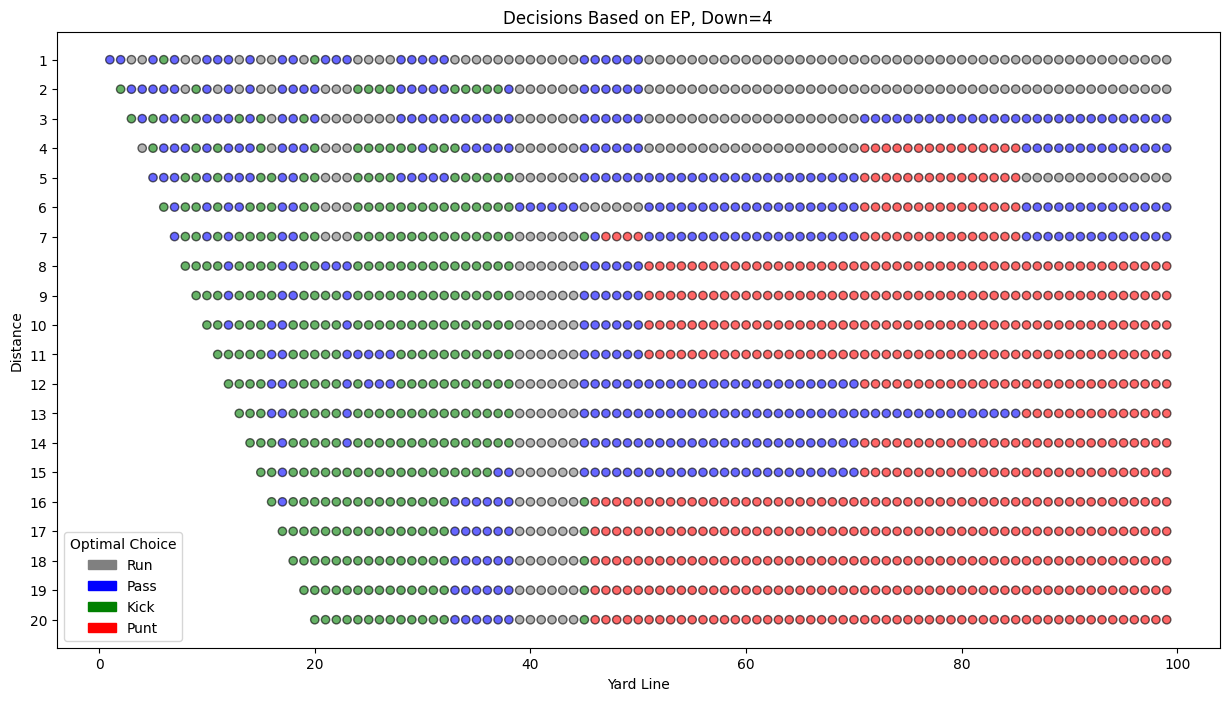

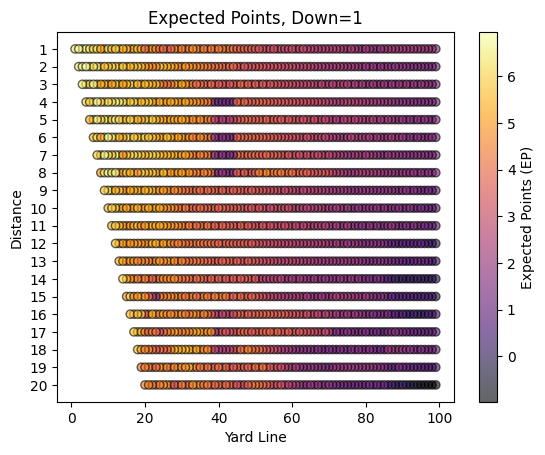

In [8]:
analyze_data('ep_data/biased_eps/final_eps.csv')
plt.show()
compare_eps('ep_data/biased_eps/final_eps.csv', 'aux_data/nfl_pbp_data.csv')
plt.show()
predicted_decisions('ep_data/biased_eps/final_eps.csv')
plt.show()
ep_visualizer('ep_data/biased_eps/final_eps.csv')
plt.show()

### NFL EP Data

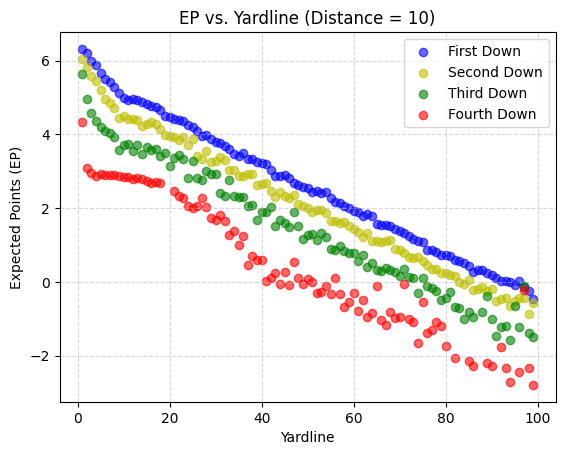

FileNotFoundError: [Errno 2] No such file or directory: 'optimal_play_types.csv'

In [9]:
analyze_data('aux_data/nfl_pbp_data.csv')
plt.show()
predicted_decisions('optimal_play_types.csv')
plt.show()
ep_visualizer('nfl_pbp_data.csv', down = 3)
plt.show()

### Analyzing EPOCHS

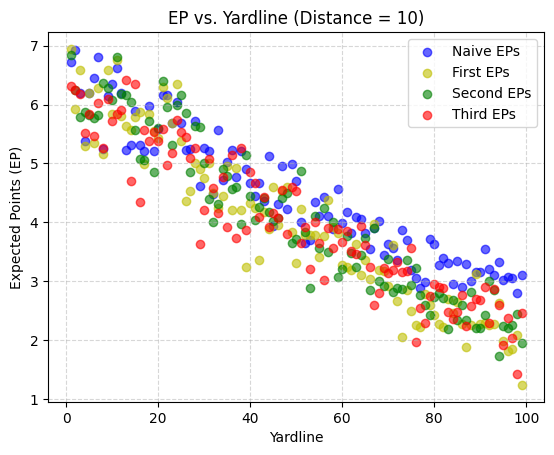

In [ ]:
analyze_epochs(down=1)
plt.show()